## Olympics Prediction Model

In [1]:
!pip install --upgrade pip
!pip install "snowflake-connector-python[pandas]" "snowflake-snowpark-python[pandas]" snowflake-snowpark-python==1.9.0 fosforio fosforml numpy pandas matplotlib scikit-learn xgboost seaborn python-dateutil tqdm holidays faker
!pip install --upgrade --q snowflake-snowpark-python==1.9.0
!pip uninstall urllib3 -y
!pip install urllib3==1.26.15
!pip install tensorflow[and-cuda]

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.8 MB/s eta 0:00:00a 0:00:01
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 240.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 219.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of fosforml to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of fosforml to determine whic

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 221.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 240.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.5/327.5 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 277.7 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 204.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 701.2/701.2 kB 332.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 223.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.9/140.9 kB 293.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 270.7 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 240.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 305.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 319.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 223.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 312.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 227.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 277.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.5/505.5 kB 329.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 230.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 199.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 277.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 330.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 304.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlflow 2.10.0 requires packaging<24, but you have packaging 24.1 which is incompatible.
mlflow 2.10.0 requires pytz<2024, but you have pytz 2024.1 which is incompatible.
fosforml 1.0.0 requires cloudpickle==1.6.0, but you have cloudpickle 2.0.0 which is incompatible.
fosforml 1.0.0 requires PyYAML==6.0, but you have pyyaml 6.0.1 which is incompatible.
fosforml 1.0.0 requires urllib3==1.26.15, but you have urllib3 1.26.19 which is incompatible.
tensorflow 2.13.1 requires numpy<=1.24.3,>=1.22, but you have numpy 1.24.4 which is incompatible.
tensorflow 2.13.1 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 223.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 118.3 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 189.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 336.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 141.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 158.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 253.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 327.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 153.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 169.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 327.2 MB/s eta 0:00:00


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 166.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 249.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 233.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.6/479.6 MB 175.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.5/195.5 kB 297.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 277.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 242.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 181.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.3/227.3 kB 310.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 241.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.0/163.0 kB 279.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 287.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

In [ ]:
import os
os._exit(00)

In [ ]:
# Import packages

In [1]:
from fosforio import snowflake
from fosforml import *
from fosforml.constants import MLModelFlavours
from fosforio import get_dataframe
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
pd.set_option('display.max_columns', 500)
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
import warnings; warnings.simplefilter('ignore')
from joblib import dump, load
import requests
from tqdm import tqdm
import time
import calendar

from time import sleep
import configparser
from dateutil.relativedelta import relativedelta
import datetime
from dateutil.easter import easter
from scipy.optimize import minimize_scalar
from scipy.optimize import curve_fit

Connection manager service url initialised to http://fdc-project-manager:80/project-manager
If you need to update its value then update the variable CONNECTION_MANAGER_BASE_URL in os env.


/tmp/pip_packages/_distutils_hack/__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
Matplotlib created a temporary cache directory at /tmp/matplotlib-hy02bvxn because the default path (/home/mosaic-ai/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
#Import Data

snowflake.get_connection(connection_name="ME_OLYMPICS_CNX")
data = get_dataframe("ATHLETE_EVENTS")
data

Exception occurred in getting snowflake connection: 'connectionSources'
Reading dataframe from snowflake native connector


,ID,NAME,SEX,AGE,HEIGHT,WEIGHT,TEAM,NOC,GAMES,YEAR,SEASON,CITY,SPORT,EVENT,MEDAL
0,1,A Dijiang,M,24,180,80,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NA
1,2,A Lamusi,M,23,170,60,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NA
2,3,Gunnar Nielsen Aaby,M,24,NA,NA,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NA
3,4,Edgar Lindenau Aabye,M,34,NA,NA,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21,185,82,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271111,135569,Andrzej ya,M,29,179,89,Poland-1,POL,1976 Winter,1976,Winter,Innsbruck,Luge,Luge Mixed (Men)'s Doubles,NA
271112,135570,Piotr ya,M,27,176,59,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",NA
271113,135570,Piotr ya,M,27,176,59,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Team",NA
271114,135571,Tomasz Ireneusz ya,M,30,185,96,Poland,POL,1998 Winter,1998,Winter,Nagano,Bobsleigh,Bobsleigh Men's Four,NA


In [4]:
data_bkp = get_dataframe("ATHLETE_EVENTS")
data_bkp

Reading dataframe from snowflake native connector


,ID,NAME,SEX,AGE,HEIGHT,WEIGHT,TEAM,NOC,GAMES,YEAR,SEASON,CITY,SPORT,EVENT,MEDAL
0,1,A Dijiang,M,24,180,80,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NA
1,2,A Lamusi,M,23,170,60,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NA
2,3,Gunnar Nielsen Aaby,M,24,NA,NA,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NA
3,4,Edgar Lindenau Aabye,M,34,NA,NA,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21,185,82,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271111,135569,Andrzej ya,M,29,179,89,Poland-1,POL,1976 Winter,1976,Winter,Innsbruck,Luge,Luge Mixed (Men)'s Doubles,NA
271112,135570,Piotr ya,M,27,176,59,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",NA
271113,135570,Piotr ya,M,27,176,59,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Team",NA
271114,135571,Tomasz Ireneusz ya,M,30,185,96,Poland,POL,1998 Winter,1998,Winter,Nagano,Bobsleigh,Bobsleigh Men's Four,NA


In [5]:
data['AGE'].value_counts().to_dict()

{'23': 21875,
 '24': 21720,
 '22': 20814,
 '25': 19707,
 '21': 19164,
 '26': 17675,
 '27': 16025,
 '20': 15258,
 '28': 14043,
 '19': 11643,
 '29': 11463,
 '30': 9488,
 'NA': 9474,
 '18': 8152,
 '31': 7559,
 '32': 6246,
 '17': 5376,
 '33': 4800,
 '34': 3985,
 '16': 3852,
 '35': 3133,
 '36': 2503,
 '15': 2203,
 '37': 1953,
 '38': 1612,
 '39': 1405,
 '40': 1210,
 '41': 953,
 '42': 866,
 '14': 837,
 '43': 793,
 '44': 683,
 '45': 584,
 '46': 429,
 '47': 408,
 '48': 407,
 '49': 362,
 '50': 278,
 '52': 244,
 '53': 200,
 '51': 199,
 '13': 187,
 '54': 162,
 '56': 131,
 '55': 104,
 '60': 88,
 '59': 87,
 '58': 84,
 '65': 84,
 '57': 69,
 '61': 68,
 '62': 62,
 '69': 60,
 '63': 56,
 '12': 39,
 '71': 33,
 '66': 31,
 '64': 30,
 '70': 28,
 '67': 25,
 '68': 25,
 '72': 24,
 '11': 13,
 '74': 12,
 '73': 8,
 '76': 7,
 '75': 4,
 '88': 3,
 '80': 3,
 '81': 2,
 '77': 2,
 '84': 1,
 '96': 1,
 '10': 1,
 '97': 1}

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   ID      271116 non-null  int32 
 1   NAME    271116 non-null  object
 2   SEX     271116 non-null  object
 3   AGE     271116 non-null  object
 4   HEIGHT  271116 non-null  object
 5   WEIGHT  271116 non-null  object
 6   TEAM    271116 non-null  object
 7   NOC     271116 non-null  object
 8   GAMES   271116 non-null  object
 9   YEAR    271116 non-null  int16 
 10  SEASON  271116 non-null  object
 11  CITY    271116 non-null  object
 12  SPORT   271116 non-null  object
 13  EVENT   271116 non-null  object
 14  MEDAL   271116 non-null  object
dtypes: int16(1), int32(1), object(13)
memory usage: 28.4+ MB


In [7]:
data['AGE'][data['AGE']!='NA'].astype(int).median()

24.0

In [8]:
data['WEIGHT'][data['WEIGHT']!='NA'].astype(float).median()

70.0

In [9]:
data['HEIGHT'][data['HEIGHT']!='NA'].astype(int).median()

175.0

In [10]:
data['AGE'].replace('NA',int(data['AGE'][data['AGE']!='NA'].astype(int).median()))

0         24
1         23
2         24
3         34
4         21
          ..
271111    29
271112    27
271113    27
271114    30
271115    34
Name: AGE, Length: 271116, dtype: object

In [11]:
data['AGE'] = data['AGE'].replace('NA',str(int(data['AGE'][data['AGE']!='NA'].astype(int).median()))).astype(int)

In [12]:
data['HEIGHT'] = data['HEIGHT'].replace('NA',str(int(data['HEIGHT'][data['HEIGHT']!='NA'].astype(int).median()))).astype(int)

In [13]:
data['WEIGHT'] = data['WEIGHT'].replace('NA',str(float(data['WEIGHT'][data['WEIGHT']!='NA'].astype(float).median()))).astype(float)

In [14]:
data['WEIGHT'].value_counts().to_dict()

{70.0: 72500,
 60.0: 7994,
 75.0: 7810,
 68.0: 7284,
 65.0: 7236,
 72.0: 6252,
 80.0: 6214,
 73.0: 5937,
 63.0: 5869,
 64.0: 5764,
 62.0: 5611,
 67.0: 5263,
 58.0: 5243,
 78.0: 4995,
 74.0: 4809,
 66.0: 4764,
 57.0: 4640,
 82.0: 4186,
 76.0: 4109,
 55.0: 4106,
 77.0: 4035,
 56.0: 4029,
 69.0: 4027,
 59.0: 4012,
 85.0: 3909,
 61.0: 3817,
 71.0: 3637,
 54.0: 3507,
 52.0: 3450,
 90.0: 3371,
 79.0: 3146,
 84.0: 2945,
 83.0: 2925,
 50.0: 2587,
 81.0: 2557,
 86.0: 2536,
 53.0: 2386,
 88.0: 2142,
 48.0: 1965,
 87.0: 1876,
 95.0: 1842,
 51.0: 1839,
 100.0: 1544,
 92.0: 1473,
 89.0: 1438,
 93.0: 1409,
 91.0: 1324,
 49.0: 1110,
 47.0: 1039,
 94.0: 990,
 98.0: 892,
 96.0: 859,
 46.0: 777,
 45.0: 746,
 97.0: 684,
 105.0: 602,
 43.0: 521,
 102.0: 504,
 44.0: 442,
 110.0: 428,
 120.0: 395,
 40.0: 372,
 99.0: 370,
 42.0: 344,
 104.0: 314,
 115.0: 292,
 41.0: 259,
 103.0: 249,
 130.0: 203,
 125.0: 199,
 39.0: 196,
 38.0: 195,
 107.0: 187,
 108.0: 174,
 106.0: 174,
 37.0: 173,
 101.0: 166,
 36.0: 137,


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      271116 non-null  int32  
 1   NAME    271116 non-null  object 
 2   SEX     271116 non-null  object 
 3   AGE     271116 non-null  int64  
 4   HEIGHT  271116 non-null  int64  
 5   WEIGHT  271116 non-null  float64
 6   TEAM    271116 non-null  object 
 7   NOC     271116 non-null  object 
 8   GAMES   271116 non-null  object 
 9   YEAR    271116 non-null  int16  
 10  SEASON  271116 non-null  object 
 11  CITY    271116 non-null  object 
 12  SPORT   271116 non-null  object 
 13  EVENT   271116 non-null  object 
 14  MEDAL   271116 non-null  object 
dtypes: float64(1), int16(1), int32(1), int64(2), object(10)
memory usage: 28.4+ MB


In [16]:
tf.random.set_seed(100)

In [17]:
data.columns = data.columns.str.lower()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      271116 non-null  int32  
 1   name    271116 non-null  object 
 2   sex     271116 non-null  object 
 3   age     271116 non-null  int64  
 4   height  271116 non-null  int64  
 5   weight  271116 non-null  float64
 6   team    271116 non-null  object 
 7   noc     271116 non-null  object 
 8   games   271116 non-null  object 
 9   year    271116 non-null  int16  
 10  season  271116 non-null  object 
 11  city    271116 non-null  object 
 12  sport   271116 non-null  object 
 13  event   271116 non-null  object 
 14  medal   271116 non-null  object 
dtypes: float64(1), int16(1), int32(1), int64(2), object(10)
memory usage: 28.4+ MB


# CREATING LABELS

In [18]:
data['medal'] = data['medal'].apply(lambda x: 1 if str(x) != 'nan' else 0)

In [19]:
data['age'].value_counts()

age
24    31194
23    21875
22    20814
25    19707
21    19164
      ...  
77        2
84        1
10        1
96        1
97        1
Name: count, Length: 74, dtype: int64

# Cleaning data

In [20]:
# converting datatypes
data = data.astype({'age': int, 'height': int, 'weight': int})
print(data.dtypes)

id         int32
name      object
sex       object
age        int64
height     int64
weight     int64
team      object
noc       object
games     object
year       int16
season    object
city      object
sport     object
event     object
medal      int64
dtype: object


In [22]:
data = data.drop(['id', 'name', 'games'], axis=1)

KeyError: "['id', 'name', 'games'] not found in axis"

In [23]:
data.isna().mean()

sex       0.0
age       0.0
height    0.0
weight    0.0
team      0.0
noc       0.0
year      0.0
season    0.0
city      0.0
sport     0.0
event     0.0
medal     0.0
dtype: float64

In [24]:
print("Total missing values:", data.isna().sum().sum())

Total missing values: 0


In [45]:
data['year'].value_counts().sort_values()

year
1896      380
1904     1301
1906     1733
1900     1936
1908     3101
1994     3160
1932     3321
1998     3605
1912     4040
2002     4109
1920     4292
2006     4382
2010     4402
2014     4891
1928     5574
1924     5693
1956     6434
1936     7401
1948     7480
1980     8937
1960     9235
1952     9358
1964     9480
1968    10479
1976    10502
1984    11588
1972    11959
2012    12920
2004    13443
2008    13602
2016    13688
1996    13780
2000    13821
1988    14676
1992    16413
Name: count, dtype: int64

In [28]:
data['season'].value_counts()

season
Summer    222552
Winter     48564
Name: count, dtype: int64

In [51]:
filtered_data = data[data['season'] == 'Summer'].reset_index()

In [52]:
filtered_data['season'].value_counts()

season
Summer    222552
Name: count, dtype: int64

In [54]:
f_data = filtered_data[filtered_data['year'] > 1960].reset_index()
f_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158148 entries, 0 to 158147
Data columns (total 14 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   level_0  158148 non-null  int64 
 1   index    158148 non-null  int64 
 2   sex      158148 non-null  object
 3   age      158148 non-null  int64 
 4   height   158148 non-null  int64 
 5   weight   158148 non-null  int64 
 6   team     158148 non-null  object
 7   noc      158148 non-null  object
 8   year     158148 non-null  int16 
 9   season   158148 non-null  object
 10  city     158148 non-null  object
 11  sport    158148 non-null  object
 12  event    158148 non-null  object
 13  medal    158148 non-null  int64 
dtypes: int16(1), int64(6), object(7)
memory usage: 16.0+ MB


In [57]:
f_data['year'].value_counts()

year
2000    13821
1996    13780
2016    13688
2008    13602
2004    13443
1992    12977
2012    12920
1988    12037
1972    10304
1984     9454
1976     8641
1968     8588
1964     7702
1980     7191
Name: count, dtype: int64

In [65]:
f_data

,sex,age,height,weight,team,year,season,city,sport,medal
0,M,24,180,80,China,1992,Summer,Barcelona,Basketball,1
1,M,23,170,60,China,2012,Summer,London,Judo,1
2,M,31,172,70,Finland,2000,Summer,Sydney,Badminton,1
3,F,30,159,55,Finland,1996,Summer,Atlanta,Sailing,1
4,F,34,159,55,Finland,2000,Summer,Sydney,Sailing,1
...,...,...,...,...,...,...,...,...,...,...
158143,M,27,168,76,Argentina,2004,Summer,Athina,Hockey,1
158144,M,21,175,75,United States,1972,Summer,Munich,Football,1
158145,M,24,183,72,Russia,2000,Summer,Sydney,Rowing,1
158146,M,28,183,72,Russia,2004,Summer,Athina,Rowing,1


In [63]:
f_data = f_data.drop(['event'], axis=1)

KeyError: "['event'] not found in axis"

In [64]:
f_data = f_data.drop(['noc', 'level_0', 'index'], axis=1)

In [92]:
f_data1 = f_data[f_data['sport'].map(f_data['sport'].value_counts()) > 1500]

In [93]:
f_data1['sport'].value_counts()

sport
Athletics        26780
Swimming         19377
Gymnastics       16433
Cycling           7494
Rowing            7418
Shooting          6939
Fencing           5747
Canoeing          5348
Wrestling         4862
Sailing           4749
Football          4615
Boxing            4380
Equestrianism     4214
Hockey            4201
Judo              3801
Handball          3560
Volleyball        3404
Basketball        3395
Weightlifting     2996
Water Polo        2609
Archery           2069
Tennis            2024
Diving            1963
Table Tennis      1955
Name: count, dtype: int64

In [117]:
f_data2 = f_data1[f_data1['team'].map(f_data1['team'].value_counts()) > 1500]

In [118]:
f_data2['team'].value_counts()

team
United States     8256
Great Britain     5661
Australia         5497
France            5129
Canada            4922
Italy             4823
Japan             4513
Germany           4265
Spain             3865
China             3766
Hungary           3667
Poland            3508
Soviet Union      3293
South Korea       3244
Russia            3047
Romania           3001
Brazil            3001
Netherlands       2862
Sweden            2633
West Germany      2504
Bulgaria          2255
East Germany      2092
Cuba              2080
Mexico            2072
Switzerland       2020
Argentina         1894
Ukraine           1863
New Zealand       1842
Czechoslovakia    1683
Greece            1549
Name: count, dtype: int64

In [119]:
f_data2['year'].value_counts()

year
1996    8383
1988    8350
2004    8170
2000    8108
2008    8070
1992    7837
2016    7670
2012    7534
1972    7342
1976    6654
1968    6187
1984    6007
1964    5448
1980    5047
Name: count, dtype: int64

# Over all filters:
Season: Summer only
Year: >1960 only
SPorts that had more than 1500 values
Team: that had more than 1500 values
    removed rep. columns like noc, event, etc.
    removing weight column as it is highly correlated to height column

# Encoding Data

In [120]:
f_data2

,sex,age,height,weight,team,year,season,city,sport,medal
0,M,24,180,80,China,1992,Summer,Barcelona,Basketball,1
1,M,23,170,60,China,2012,Summer,London,Judo,1
7,F,22,170,125,Romania,2016,Summer,Rio de Janeiro,Weightlifting,1
10,M,26,175,70,Netherlands,1984,Summer,Los Angeles,Water Polo,1
13,F,22,175,70,Netherlands,1988,Summer,Seoul,Hockey,1
...,...,...,...,...,...,...,...,...,...,...
158142,M,23,168,76,Argentina,2000,Summer,Sydney,Hockey,1
158143,M,27,168,76,Argentina,2004,Summer,Athina,Hockey,1
158144,M,21,175,75,United States,1972,Summer,Munich,Football,1
158145,M,24,183,72,Russia,2000,Summer,Sydney,Rowing,1


In [168]:
f_data2 = f_data2.drop(['height'], axis=1)

In [169]:
{column: len(f_data2[column].unique()) for column in f_data2.select_dtypes('object').columns}

{'sex': 2, 'team': 30, 'season': 1, 'city': 14, 'sport': 24}

In [170]:
def binary_encode(df, columns, positive_values):
    df = df.copy()
    for column, positive_value in zip(columns, positive_values):
        df[column] = df[column].apply(lambda x: 1 if x == positive_value else 0)
    return df

def onehot_encode(df, columns, prefixes):
    df = df.copy()
    for column, prefix in zip(columns, prefixes):
        dummies = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

#df = binary_encode(
    f_data2,
    columns=['sex', 'season'],
    positive_values=['M', 'Summer']
)



In [171]:
df1 = onehot_encode(
    f_data2,
    columns=['sex','team', 'city', 'sport'],
    prefixes=['sex','t', 'c', 's']
)

In [172]:
print("Remaining non-numeric columns:", len(df1.select_dtypes('object').columns))

Remaining non-numeric columns: 1


In [173]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100807 entries, 0 to 158146
Data columns (total 75 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   age               100807 non-null  int64 
 1   weight            100807 non-null  int64 
 2   year              100807 non-null  int16 
 3   season            100807 non-null  object
 4   medal             100807 non-null  int64 
 5   sex_F             100807 non-null  bool  
 6   sex_M             100807 non-null  bool  
 7   t_Argentina       100807 non-null  bool  
 8   t_Australia       100807 non-null  bool  
 9   t_Brazil          100807 non-null  bool  
 10  t_Bulgaria        100807 non-null  bool  
 11  t_Canada          100807 non-null  bool  
 12  t_China           100807 non-null  bool  
 13  t_Cuba            100807 non-null  bool  
 14  t_Czechoslovakia  100807 non-null  bool  
 15  t_East Germany    100807 non-null  bool  
 16  t_France          100807 non-null  bool  
 

In [174]:
df1 = df1.drop(['season'], axis=1)

In [175]:
df1.reset_index()
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100807 entries, 0 to 158146
Data columns (total 74 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   age               100807 non-null  int64
 1   weight            100807 non-null  int64
 2   year              100807 non-null  int16
 3   medal             100807 non-null  int64
 4   sex_F             100807 non-null  bool 
 5   sex_M             100807 non-null  bool 
 6   t_Argentina       100807 non-null  bool 
 7   t_Australia       100807 non-null  bool 
 8   t_Brazil          100807 non-null  bool 
 9   t_Bulgaria        100807 non-null  bool 
 10  t_Canada          100807 non-null  bool 
 11  t_China           100807 non-null  bool 
 12  t_Cuba            100807 non-null  bool 
 13  t_Czechoslovakia  100807 non-null  bool 
 14  t_East Germany    100807 non-null  bool 
 15  t_France          100807 non-null  bool 
 16  t_Germany         100807 non-null  bool 
 17  t_Great Britain

# Visualizing Correlations

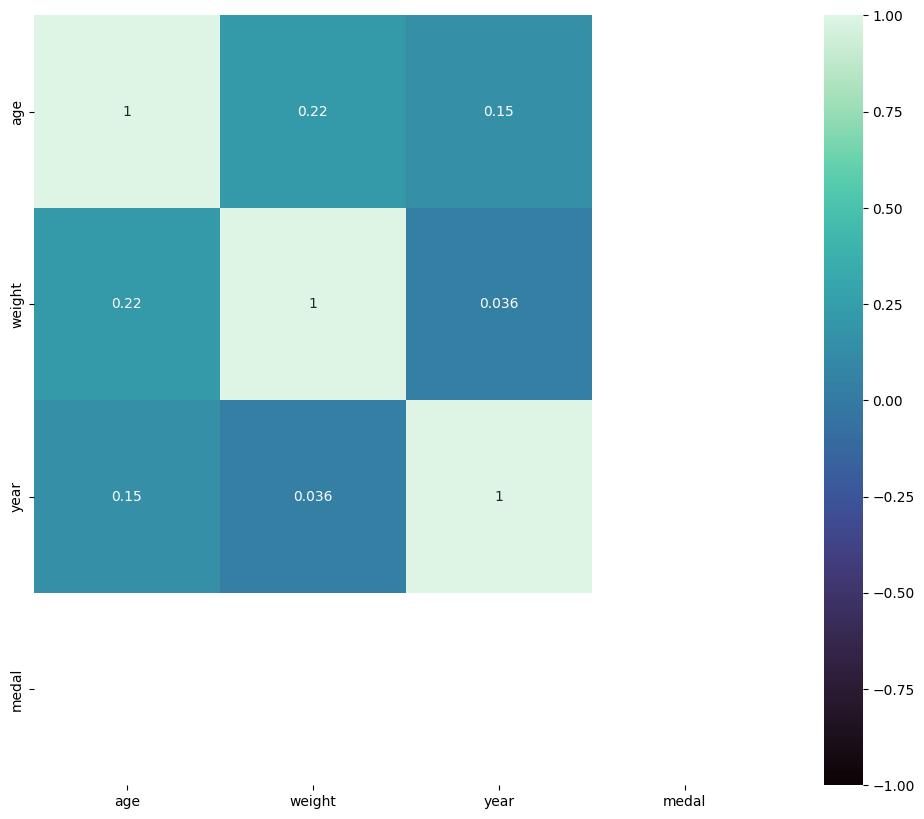

In [176]:
corr = df1.loc[:, :'medal'].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, vmin=-1.0, cmap='mako')
plt.show()

In [ ]:
df1.

In [177]:
grouped_data = df1.groupby('team')['medal'].sum()

KeyError: 'team'

# Splitting/Scaling

In [ ]:
#data

In [ ]:
y = data['medal'].copy()
X = data.drop('medal', axis=1).copy()

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=100)

# Training

In [ ]:
X.shape

In [ ]:
print("Class Distribution (Positive to Negative): {:.1f}% / {:.1f}%".format(y_train.mean() * 100, (1 - y_train.mean()) * 100))

In [ ]:
inputs = tf.keras.Input(shape=(X.shape[1]))
x = tf.keras.layers.Dense(64, activation='relu')(inputs)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)


history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

# Results

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
y_true = np.array(y_test)
y_pred = np.squeeze(np.array(model.predict(X_test) >= 0.5, dtype=np.int))

In [ ]:
print("Classification Report:\n\n", classification_report(y_true, y_pred))

In [ ]:
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

In [ ]:
y_pred